<a href="https://colab.research.google.com/github/TheoPantaz/Motor-Imagery-Classification-with-Tensorflow-and-MNE/blob/master/Motor_Imagery_clsf.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Install mne

In [2]:
!pip install mne


     |████████████████████████████████| 6.8MB 6.1MB/s 


Import libraries

In [4]:
import scipy.io as sio
import sklearn.preprocessing as skpr
import mne
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt


Import data


In [5]:
from google.colab import drive
drive.mount('/content/drive')

def import_from_mat(filename):
    dataset = sio.loadmat(filename, chars_as_strings = True)
    return dataset['EEG'], dataset['LABELS'].flatten(), dataset['Fs'][0][0], dataset['events'].T

filename = '/content/drive/My Drive/PANTAZ_s2'
EEG, LABELS, Fs, events = import_from_mat(filename)

Mounted at /content/drive


Normalize data

In [6]:
def standardize(data):
    scaler = skpr.StandardScaler()
    return scaler.fit_transform(data)

EEG = standardize(EEG)

Create mne object

In [7]:
channel_names = ['c1', 'c2', 'c3', 'c4', 'cp1', 'cp2', 'cp3', 'cp4']
channel_type = 'eeg'

def create_mne_object(EEG, channel_names, channel_type):
    info = mne.create_info(channel_names, Fs, ch_types = channel_type)
    raw = mne.io.RawArray(EEG.T, info)
    return raw

raw = create_mne_object(EEG, channel_names, channel_type)

Creating RawArray with float64 data, n_channels=8, n_times=400000
    Range : 0 ... 399999 =      0.000 ...  1599.996 secs
Ready.


filtering

In [8]:
def filtering(raw, low_freq, high_freq):
    # Notch filtering
    freqs = (50, 100)
    raw = raw.notch_filter(freqs = freqs)

    # Apply band-pass filter
    raw.filter(low_freq, high_freq, fir_design = 'firwin', skip_by_annotation = 'edge')
    return raw
    
low_freq = 7.
high_freq = 30.
filtered = filtering(raw, low_freq, high_freq)

Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.604 sec)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.00 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 413 samples (1.652 sec)



Epoching the data

In [9]:
def Epoch_Setup(events, IM_dur, step, last_start_of_epoch): 
  IM_dur = int(IM_dur * Fs)
  step = int(step * IM_dur)
  last_start_of_epoch = int(last_start_of_epoch * IM_dur)
  steps_sum = int(last_start_of_epoch / step)
  new_events = [[],[],[]]

  for index in events:
    new_events[0].extend(np.arange(index[0], index[0] + last_start_of_epoch, step))
    new_events[1].extend([0] * steps_sum) 
    new_events[2].extend([index[-1]] * steps_sum) 
  new_events = np.array(new_events).T
  return new_events

def Epochs(data, events, tmin, tmax):
  epochs = mne.Epochs(data, events=events, tmin=tmin, tmax=tmax, preload=True, baseline=None, proj=True)
  epoched_data = epochs.get_data()
  labels = epochs.events[:, -1] - 1
  return epoched_data, labels

IM_dur = 4 
step = 1/40
last_start_of_epoch = 0.5

tmix = -1
tmax = 2

new_events = Epoch_Setup(events, IM_dur, step, last_start_of_epoch)
epoched_data, labels = Epochs(filtered, new_events, tmix, tmax)

Not setting metadata
Not setting metadata
4000 matching events found
No baseline correction applied
0 projection items activated
Loading data for 4000 events and 751 original time points ...
0 bad epochs dropped


Split training and testing data

In [10]:
def data_split(data, labels, split):
  split = int(split * data.shape[0])
  X_train = epoched_data[:split]
  X_test = epoched_data[split:]
  Y_train = labels[:split]
  Y_test = labels[split:]
  return X_train, X_test, Y_train, Y_test

split = 0.5
X_train, X_test, Y_train, Y_test = data_split(epoched_data, labels, split)

CSP fit and transform function

In [11]:
def csp_fit_transform(X_train, labels, X_test):
  csp = mne.decoding.CSP(n_components=8, reg='oas', log = True, norm_trace=True)
  X_train = csp.fit_transform(X_train, labels)
  X_test = csp.transform(X_test)
  return (X_train, X_test)

X_train, X_test = csp_fit_transform(X_train, Y_train, X_test)


Computing rank from data with rank=None
    Using tolerance 0.044 (2.2e-16 eps * 8 dim * 2.5e+13  max singular value)
    Estimated rank (mag): 8
    MAG: rank 8 computed from 8 data channels with 0 projectors
Reducing data rank from 8 -> 8
Estimating covariance using OAS
Done.
Computing rank from data with rank=None
    Using tolerance 0.035 (2.2e-16 eps * 8 dim * 2e+13  max singular value)
    Estimated rank (mag): 8
    MAG: rank 8 computed from 8 data channels with 0 projectors
Reducing data rank from 8 -> 8
Estimating covariance using OAS
Done.


Create tensorflow model

In [12]:
#compare tensorflow and sklearn pipelines, check out idea for sklearn pipeline and tensorflow model inside

model = tf.keras.Sequential([
    tf.keras.layers.LSTM(128,  input_shape = [20,8], return_sequences = True),
    tf.keras.layers.LSTM(256),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(64, activation = 'relu'),
    tf.keras.layers.Dense(64, activation = 'relu'),
    tf.keras.layers.Dense(1, activation = 'sigmoid')        
])
model.compile(loss='binary_crossentropy',optimizer=tf.keras.optimizers.Adam(lr = 0.0001),metrics=['accuracy'])
model.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 20, 128)           70144     
_________________________________________________________________
lstm_1 (LSTM)                (None, 256)               394240    
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense (Dense)                (None, 64)                16448     
_________________________________________________________________
dense_1 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 65        
Total params: 485,057
Trainable params: 485,057
Non-trainable params: 0
__________________________________________________

Data reshape for Tensorflow model

In [13]:
def reshape_data(X_train, X_test, labels, reshape_factor):
  X_train = np.reshape(X_train, (int(X_train.shape[0]/reshape_factor),reshape_factor,8))
  X_test = np.reshape(X_test, (int(X_test.shape[0]/reshape_factor),reshape_factor,8))
  Y_train = LABELS[:X_train.shape[0]] - 1
  Y_test = LABELS[X_train.shape[0]:] - 1
  return X_train, X_test, Y_train, Y_test

reshape_factor = 20
X_train, X_test, Y_train, Y_test = reshape_data(X_train, X_test, labels, reshape_factor)  

Model fit

In [14]:
history = model.fit(X_train, Y_train, epochs= 100, batch_size = 4, validation_data=(X_test, Y_test), verbose=1)

Epoch 1/100
25/25 [==============================] - 1s 41ms/step - loss: 0.6960 - accuracy: 0.5000 - val_loss: 0.6785 - val_accuracy: 0.6200
Epoch 2/100
25/25 [==============================] - 0s 9ms/step - loss: 0.6656 - accuracy: 0.6700 - val_loss: 0.6432 - val_accuracy: 0.7200
Epoch 3/100
25/25 [==============================] - 0s 9ms/step - loss: 0.5931 - accuracy: 0.8600 - val_loss: 0.5353 - val_accuracy: 0.8100
Epoch 4/100
25/25 [==============================] - 0s 8ms/step - loss: 0.3876 - accuracy: 0.9100 - val_loss: 0.4113 - val_accuracy: 0.8000
Epoch 5/100
25/25 [==============================] - 0s 9ms/step - loss: 0.3017 - accuracy: 0.8900 - val_loss: 0.3418 - val_accuracy: 0.8100
Epoch 6/100
25/25 [==============================] - 0s 8ms/step - loss: 0.4115 - accuracy: 0.8100 - val_loss: 0.4090 - val_accuracy: 0.8300
Epoch 7/100
25/25 [==============================] - 0s 8ms/step - loss: 0.2962 - accuracy: 0.8600 - val_loss: 0.2810 - val_accuracy: 0.9200
Epoch 8/100


Accuracy and plot loss

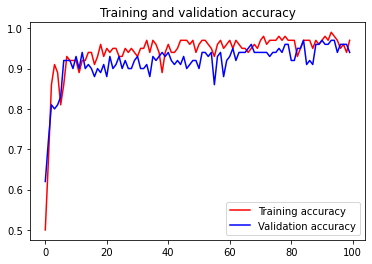

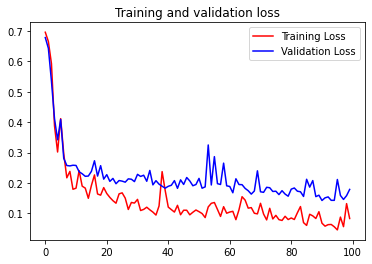

In [15]:
%matplotlib inline
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()